In [11]:
import numpy as np
#might not need torch
#conda install pytorch torchvision torchaudio -c pytorch
# Load data from .npy file
#dataset from here: https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection/data

#pip install mtcnn
from mtcnn import MTCNN
import cv2
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split

# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

detector = MTCNN()

from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array
model = model_from_json(open("sources/86ta68va.json", "r").read())
model.load_weights("sources/86ta68va.h5")


In [4]:
def alignFaces(image, leftEye, rightEye, bounding_box):
    '''align image to flat given a source image as well as the level of the two eyes'''
    # Calculate the rotation angle based on the positions of the eyes
    dy = rightEye[1] - leftEye[1]
    dx = rightEye[0] - leftEye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Calculate the midpoint between the eyes
    midpoint = ((leftEye[0] + rightEye[0]) // 2, (leftEye[1] + rightEye[1]) // 2)

    # Rotation matrix (no scaling)
    M = cv2.getRotationMatrix2D(midpoint, angle, 1.0)

    # Apply affine transformation to the input image (no scaling)
    aligned_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    # Rotate the bounding box
    bbox_points = np.array([[bounding_box[0], bounding_box[1]], 
                            [bounding_box[0] + bounding_box[2], bounding_box[1]], 
                            [bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]], 
                            [bounding_box[0], bounding_box[1] + bounding_box[3]]], dtype=np.float32)
    rotated_bbox_points = cv2.transform(np.array([bbox_points]), M)[0]
    x, y, w, h = cv2.boundingRect(rotated_bbox_points)
    
    return aligned_image, x, y, w, h

1/1 [==============================] - 0s 16ms/step


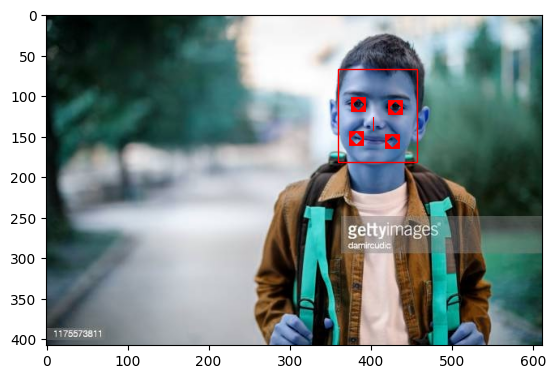

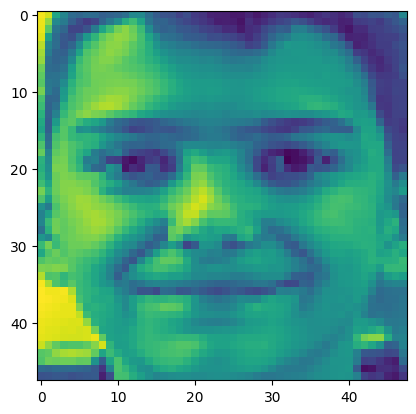

In [32]:
# load the input image and convert it to grayscale
# image = cv2.imread('sources/images/00000008.jpg')
#image = cv2.imread('sources/raoul.png')
image = cv2.imread('sources/images/00003154.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect the face using MTCNN
result = detector.detect_faces(image)
if result:
    bounding_box = result[0]['box']
    keypoints = result[0]['keypoints']

    # Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    # Create a Rectangle patch
    rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    # Visualize all the internal features
    for key in keypoints:
        rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
        ax.add_patch(rect_key)
    
    #left eye, right eye, nose, left mouth corner, right mouth corner
    #{'left_eye': (384, 110), 'right_eye': (430, 114), 'nose': (403, 134), 'mouth_left': (382, 152), 'mouth_right': (426, 156)}
    # Show the plots
    plt.show()

    # Extract the coordinates of the eyes
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']
    aligned_image, x, y, w, h = alignFaces(gray, left_eye, right_eye, bounding_box)
    # plt.imshow(aligned_image)
    cropped_image = aligned_image[y:y+h, x:x+w]
    # Resize the cropped face to the desired resolution of 48x48 pixels
    resized_image = cv2.resize(cropped_image, (48, 48))
    # Add an additional dimension to the resized face to make it (48, 48, 1)
    #resized_face = resized_face[..., np.newaxis]
    resized_image = resized_image/255
    plt.imshow(resized_image)
    final_image = resized_image.reshape(1, 48, 48, 1)


In [46]:
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


1/1 [==============================] - 0s 371ms/step
[[4.7816694e-04 3.9390630e-05 2.0649433e-03 6.2129349e-01 2.7907235e-03
  4.1991198e-03 3.6913410e-01]]
Predicted class: Happy


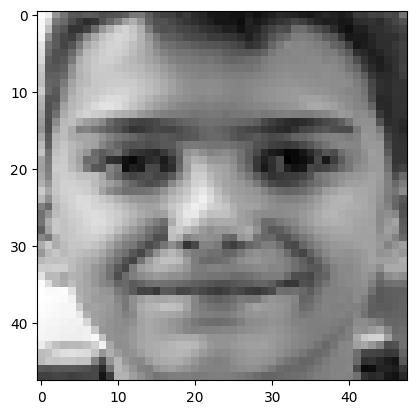

In [70]:
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

predictions = model.predict(final_image)
print(predictions)
predicted_class = np.argmax(predictions)

# Display the prediction

plt.imshow(final_image.squeeze(), cmap='gray')

print("Predicted class:",emotion_labels[predicted_class] )

In [5]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect the face using MTCNN
    result = detector.detect_faces(image)
    if result:
        bounding_box = result[0]['box']
        keypoints = result[0]['keypoints']

        # Extract the coordinates of the eyes
        left_eye = keypoints['left_eye']
        right_eye = keypoints['right_eye']

        aligned_image, x, y, w, h = alignFaces(gray, left_eye, right_eye, bounding_box)
        # Adjust bounding box coordinates for the aligned image
        # original_bounding_box = [x, y, w, h]
        cropped_image = aligned_image[y:y+h, x:x+w]
        resized_image = cv2.resize(cropped_image, (48, 48))
        final_image = resized_image.reshape(1, 48, 48, 1)
        final_image = final_image/255
        return final_image, bounding_box
    else:
        return None, None  # No face detected, return None

In [6]:
def detect_multiple(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces using MTCNN
    result = detector.detect_faces(image)
    final_images = []
    bounding_boxes = []

    # Iterate over detected faces
    for face_data in result:
        bounding_box = face_data['box']
        keypoints = face_data['keypoints']
        left_eye = keypoints['left_eye']
        right_eye = keypoints['right_eye']

        # Align and resize the face
        aligned_image, x, y, w, h = alignFaces(gray, left_eye, right_eye, bounding_box)
        cropped_image = aligned_image[y:y+h, x:x+w]
        resized_image = cv2.resize(cropped_image, (48, 48))
        final_image = resized_image.reshape(1, 48, 48, 1)
        final_image = final_image / 255  # Normalize pixel values

        # Store final image and bounding box
        final_images.append(final_image)
        bounding_boxes.append(bounding_box)

    return final_images, bounding_boxes

## Connect to the Webcam

In [7]:
import threading
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
#Based on output of chatGPT, with some modification


In [49]:
def calculate_logits(frame):
    # Dummy function for generating logits
    
    # put model prediciton result here
    # Replace this with your actual logit calculation based on the frame    
    
    # CODE TODO

    
    faces_emotions=['Happiness','Sadness','Anger','Fear','Surprise','Disgust','Contempt']
    return np.random.rand(7),faces_emotions

In [52]:

Finalmodel = model_from_json(open("Models/seq.json", "r").read())
Finalmodel.load_weights("Models/FerSeqWeightsBest.h5")

In [ ]:
class WebcamViewer:
    def __init__(self):
        self.cap = cv2.VideoCapture(0)
        self.output = widgets.Image(layout={'border': '1px solid black'})
        self.container = widgets.VBox([self.output])
        self.display_container()
        self.running = True
        self.update_thread = threading.Thread(target=self.update)
        self.update_thread.start()
        self.emotionLabels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    def display_container(self):
        display(self.container)

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                # Detect face and align if found
                final_image, bounding_box = detect_face(frame)
                if final_image is not None:
                    # Draw bounding box around the face
                    if bounding_box is not None:
                        x, y, w, h = bounding_box
                        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                        # Display emotion label            
                        predictions = Finalmodel.predict(final_image)
                        predicted_class = np.argmax(predictions)
                        predicted_prob = predictions[0][predicted_class]
                        emotion_label = f'{self.emotionLabels[predicted_class]} ({predicted_prob:.2f})'
                        # Display the prediction
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        cv2.putText(frame, emotion_label , (x, y-10), font, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
                    # Convert the image format from OpenCV BGR to PIL format
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    # Convert PIL image to byte array
                    img = Image.fromarray(frame)
                    img_byte_arr = img._repr_png_()
                    # Update the widget in the main thread
                    display(self.container)
                    self.output.value = img_byte_arr

    def close(self):
        self.running = False
        self.cap.release()

# Create and display the webcam viewer
webcam_viewer = WebcamViewer()

In [ ]:
class WebcamViewerMulti:
    def __init__(self):
        self.cap = cv2.VideoCapture(0)
        self.output = widgets.Image(layout={'border': '1px solid black'})
        self.container = widgets.VBox([self.output])
        self.display_container()
        self.running = True
        self.update_thread = threading.Thread(target=self.update)
        self.update_thread.start()
        self.emotionLabels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    def display_container(self):
        display(self.container)

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                # Detect multiple faces and get final images and bounding boxes
                final_images, bounding_boxes = detect_multiple(frame)
                for final_image, bounding_box in zip(final_images, bounding_boxes):
                    if final_image is not None:
                        # Draw bounding box around the face
                        x, y, w, h = bounding_box
                        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                        # Display emotion label            
                        predictions = Finalmodel.predict(final_image)
                        predicted_class = np.argmax(predictions)
                        predicted_prob = predictions[0][predicted_class]
                        emotion_label = f'{self.emotionLabels[predicted_class]} ({predicted_prob:.2f})'
                        # Display the prediction
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        cv2.putText(frame, emotion_label , (x, y-10), font, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
                
                # Convert the image format from OpenCV BGR to PIL format
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Convert PIL image to byte array
                img = Image.fromarray(frame)
                img_byte_arr = img._repr_png_()
                # Update the widget in the main thread
                display(self.container)
                self.output.value = img_byte_arr

    def close(self):
        self.running = False
        self.cap.release()

# Create and display the webcam viewer
webcam_viewer = WebcamViewerMulti()

In [47]:
vgg_model = model_from_json(open("Models/VGGModel.json", "r").read())
vgg_model.load_weights("Models/VGGModel.h5")
final_image_rgb = np.repeat(final_image, 3, axis=-1)
print(final_image_rgb.shape)
predictions = vgg_model.predict(final_image_rgb)
print(predictions)


(1, 48, 48, 3)
1/1 [==============================] - 0s 118ms/step
[[0.14627133 0.00036687 0.04919823 0.30744517 0.08854653 0.11897503
  0.28919688]]


In [ ]:
class WebcamViewerVGG:
    def __init__(self):
        self.cap = cv2.VideoCapture(0)
        self.output = widgets.Image(layout={'border': '1px solid black'})
        self.container = widgets.VBox([self.output])
        self.display_container()
        self.running = True
        self.update_thread = threading.Thread(target=self.update)
        self.update_thread.start()
        self.emotionLabels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    def display_container(self):
        display(self.container)

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                # Detect face and align if found
                final_image, bounding_box = detect_face(frame)
                if final_image is not None:
                    # Draw bounding box around the face
                    if bounding_box is not None:
                        x, y, w, h = bounding_box
                        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                        # Display emotion label 
                        final_image_rgb = np.repeat(final_image, 3, axis=-1)        
                        predictions = vgg_model.predict(final_image_rgb)
                        predicted_class = np.argmax(predictions)
                        predicted_prob = predictions[0][predicted_class]
                        emotion_label = f'{self.emotionLabels[predicted_class]} ({predicted_prob:.2f})'
                        # Display the prediction
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        cv2.putText(frame, emotion_label , (x, y-10), font, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
                    # Convert the image format from OpenCV BGR to PIL format
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    # Convert PIL image to byte array
                    img = Image.fromarray(frame)
                    img_byte_arr = img._repr_png_()
                    # Update the widget in the main thread
                    display(self.container)
                    self.output.value = img_byte_arr

    def close(self):
        self.running = False
        self.cap.release()

# Create and display the webcam viewer
webcam_viewer = WebcamViewerVGG()

In [ ]:
webcam_viewer.close()
# webcam_viewer_vgg.close()